[You can map via NBViewer](https://nbviewer.jupyter.org/github/taakuu/Coursera_Capstone/blob/main/Week3_Segmenting_and_Clustering_Neighborhoods.ipynb)

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a bar. Specifically, this report will be targeted to stakeholders interested in opening an **Bar** in **Tokyo**, Japan.

Since there are lots of bars in Tokyo we will try to detect **locations that are not already crowded with bars**. We are also particularly interested in **areas with no Bars in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing bars in the neighborhood (any type of bar)
* number of and distance to bars in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of bars and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Tokyo center will be obtained using **Google Maps API geocoding** of well known Tokyo location

--------------------------------

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium==0.5.0
import folium # map rendering library

from bs4 import BeautifulSoup
print('Libraries imported.')

Libraries imported.


### Postal code in Tokyo

In [2]:
!wget -q -O 'ken_all_rome.zip' "https://www.post.japanpost.jp/zipcode/dl/roman/ken_all_rome.zip?200708"
print('Data downloaded!')

Data downloaded!


In [3]:
!rm KEN_ALL_ROME.CSV 
!unzip 'ken_all_rome.zip'
print('Unzip completed')

Archive:  ken_all_rome.zip
  inflating: KEN_ALL_ROME.CSV        
Unzip completed


In [4]:
zipcode = pd.read_csv('KEN_ALL_ROME.CSV', header=None, encoding='shift_jis')
print(zipcode.shape)
#zipcode.head()

(124433, 7)


In [5]:
zipcode = zipcode[zipcode[4]=='TOKYO TO'].reset_index(drop=True)
print(zipcode.shape)
#zipcode.head()

(4005, 7)


In [6]:
zipcode.drop(index=zipcode.index[[0]],
             columns=zipcode.columns[[1,4]], inplace=True)
zipcode.reset_index(inplace=True, drop=True)
zipcode.columns = ['Postal_code', 'Borough_J', 'Town_J', 'Borough', 'Town']
zipcode.head(10)

,Postal_code,Borough_J,Town_J,Borough,Town
0,1020072,千代田区,飯田橋,CHIYODA KU,IIDABASHI
1,1020082,千代田区,一番町,CHIYODA KU,ICHIBANCHO
2,1010032,千代田区,岩本町,CHIYODA KU,IWAMOTOCHO
3,1010047,千代田区,内神田,CHIYODA KU,UCHIKANDA
4,1000011,千代田区,内幸町,CHIYODA KU,UCHISAIWAICHO
5,1000004,千代田区,大手町 （次のビルを除く）,CHIYODA KU,OTEMACHI (TSUGINOBIRUONOZOKU)
6,1006890,千代田区,大手町 ＪＡビル（地階・階層不明）,CHIYODA KU,OTEMACHI JIEIEIBIRU(CHIKAI.KAISOFUM
7,1006801,千代田区,大手町 ＪＡビル（１階）,CHIYODA KU,OTEMACHI JIEIEIBIRU(1-KAI)
8,1006802,千代田区,大手町 ＪＡビル（２階）,CHIYODA KU,OTEMACHI JIEIEIBIRU(2-KAI)
9,1006803,千代田区,大手町 ＪＡビル（３階）,CHIYODA KU,OTEMACHI JIEIEIBIRU(3-KAI)


We cannot use Japanes postal code for Neighborhoods because too many postal code in Tokyo.

### Foreign residents in Tokyo

In [7]:
!wget -q -O '2018_foreign_residents.csv' "https://www.toukei.metro.tokyo.lg.jp/tnenkan/2018/tn18qv020400.csv"
print("Data downloaded")

Data downloaded


In [8]:
foreign = pd.read_csv('2018_foreign_residents.csv', encoding='shift_jis', skiprows=10)
print(foreign.shape)
foreign.head()

(66, 21)


,11,年次\n(平成),Year,階層\nコード,地域\nコード,地域,district,総数 Total,中国 China,韓国 Rep. of Korea,ベトナム Vietnam,フィリピン Philippines,ネパール Nepal,台湾 Taiwan,アメリカ U.S.A.,イ ン ド India,ミャンマー Myanmar,タイ Thailand,その他 Others,Unnamed: 19,Unnamed: 20
0,12,27,2015,0,13000,総数,Tokyo-to,417442,172769,94010,14645,28681,14355,…,16097,8730,5627,7154,55374,NaN,NaN
1,13,28,2016,0,13000,総数,Tokyo-to,449042,185982,93309,22131,29575,18412,…,16411,9475,7044,7370,59333,NaN,NaN
2,14,29,2017,0,13000,総数,Tokyo-to,486346,185883,88755,27762,30761,22660,17281,16939,10354,8249,7651,70051,NaN,NaN
3,15,30,2018,0,13000,総数,Tokyo-to,521500,199949,90438,32334,32089,26157,18568,17578,11153,9719,7958,75557,NaN,NaN
4,16,31,2019,0,13000,総数,Tokyo-to,551683,213767,92418,36227,33219,27290,19726,18508,12130,10395,8101,79902,NaN,NaN


In [9]:
foreign = foreign[foreign['階層\nコード'] > 1]
foreign.reset_index(inplace=True, drop=True)
print(foreign.shape)
#foreign

(57, 21)


In [10]:
foreign.drop(columns=foreign.columns[[0,1,2,3,5,19,20]], inplace=True)
foreign.columns = ["Municipal_code","Borough","FR_total","FR_China","FR_Rep_of_Korea","FR_Vietnam","FR_Philippines","FR_Nepal","FR_Taiwan","FR_USA","FR_India","FR_Myanmar","FR_Thailand","FR_Others"]
print(foreign.shape)
#foreign

(57, 14)


In [11]:
# Drop subtotal rows
foreign = foreign[~foreign.Borough.str.startswith('All')]
foreign.reset_index(inplace=True, drop=True)
print(foreign.shape)
#foreign

(57, 14)


In [12]:
# For merge purpose, add one to the code of '*-shicho' in order to change to the code of '*-mura'.
foreign['Municipal_code'] = foreign['Municipal_code'].apply(lambda x: x + 1 if x in {13360,13380,13400,13420} else x)
print(foreign.shape)
#foreign

(57, 14)


In [13]:
# Split Borough name into Borough and suffix 
Borough_kind = foreign['Borough'].str.split('-', expand=True)
Borough_kind.rename(columns={0: 'Borough', 1: 'Borough_suffix'}, inplace=True)
Borough_kind.head()

,Borough,Borough_suffix
0,Chiyoda,ku
1,Chuo,ku
2,Minato,ku
3,Shinjuku,ku
4,Bunkyo,ku


In [14]:
foreign['Borough'] = Borough_kind['Borough']
foreign.insert(2, 'Borough_suffix', Borough_kind['Borough_suffix'])
print(foreign.shape)
foreign

(57, 15)


,Municipal_code,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others
0,13101,Chiyoda,ku,2996,1250,455,76,64,24,194,210,79,16,46,582
1,13102,Chuo,ku,7651,3266,1401,192,153,95,385,391,275,38,89,1366
2,13103,Minato,ku,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447
3,13104,Shinjuku,ku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830
4,13105,Bunkyo,ku,10808,4646,1658,927,223,364,509,329,107,317,192,1536
5,13106,Taito,ku,15433,6489,3118,824,785,688,503,253,713,134,334,1592
6,13107,Sumida,ku,12645,5874,1966,679,1349,320,401,183,140,75,388,1270
7,13108,Koto,ku,29472,14783,4557,1030,1585,583,703,467,2065,436,366,2897
8,13109,Shinagawa,ku,13042,4317,2426,547,798,712,600,607,402,292,196,2145
9,13110,Meguro,ku,9102,1836,1498,202,537,252,469,979,198,54,165,2912


### COVIT19 Test positives in Tokyo

In [15]:
!wget -O 'covit19_tokyo.json' 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/patient.json'
print("Download completed")

--2021-02-28 03:39:03--  https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/patient.json
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 13804 (13K) [text/plain]
`covit19_tokyo.json' に保存中

covit19_tokyo.json  100%[===================>]  13.48K  --.-KB/s 時間 0s         

2021-02-28 03:39:03 (45.4 MB/s) - `covit19_tokyo.json' へ保存完了 [13804/13804]

Download completed


In [71]:
import json
fd = open('covit19_tokyo.json', mode='r')
d = json.load(fd)
s_target = json.dumps(d['datasets']['data'])
covit = pd.read_json(s_target)
print(covit.shape)
covit.head()

(65, 5)


,code,area,label,ruby,count
0,131016.0,特別区,千代田区,ちよだく,600
1,131024.0,特別区,中央区,ちゅうおうく,1825
2,131032.0,特別区,港区,みなとく,3790
3,131041.0,特別区,新宿区,しんじゅくく,6534
4,131059.0,特別区,文京区,ぶんきょうく,1683


In [17]:
covit.dropna(subset=['code'],inplace=True)
covit.drop(columns=covit.columns[[1,3]], inplace=True)
covit['code'] = (covit['code'] / 10).astype(int)
covit.columns = ["Municipal_code","Borough_J","COVIT_positive"]
print(covit.shape)
covit

(62, 3)


,Municipal_code,Borough_J,COVIT_positive
0,13101,千代田区,600
1,13102,中央区,1825
2,13103,港区,3790
3,13104,新宿区,6534
4,13105,文京区,1683
5,13106,台東区,2066
6,13107,墨田区,2147
7,13108,江東区,3565
8,13109,品川区,3245
9,13110,目黒区,3046


### Merge Foreign residents and COVIT19 Test positives in Tokyo

In [18]:
#covit_foreign = pd.merge(covit, foreign, on='Municipal_code', how='outer', indicator=True)
covit_foreign = pd.merge(covit, foreign, on='Municipal_code')
print(covit_foreign.shape)
covit_foreign.head()

(57, 17)


,Municipal_code,Borough_J,COVIT_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others
0,13101,千代田区,600,Chiyoda,ku,2996,1250,455,76,64,24,194,210,79,16,46,582
1,13102,中央区,1825,Chuo,ku,7651,3266,1401,192,153,95,385,391,275,38,89,1366
2,13103,港区,3790,Minato,ku,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447
3,13104,新宿区,6534,Shinjuku,ku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830
4,13105,文京区,1683,Bunkyo,ku,10808,4646,1658,927,223,364,509,329,107,317,192,1536


### Add Longitude and Latitude in COVIT positive and Foreign residents dataFrame 

In [19]:
from functools import partial
from geopy.geocoders import Nominatim 
geolocator = Nominatim(user_agent="tokyo_explorer")
_geocode = partial(geolocator.geocode, language="en")
#f_geocode = lambda query, **kw: _geocode("%s, Tokyo, Japan" % query, **kw)
covit_foreign['Address'] = covit_foreign['Borough'] + ', Tokyo, Japan'
#f_get_lon_lat = lambda x: (x.latitude, x.longitude)
f_get_lon_lat = lambda x: (None, None) if x is None else (x.latitude, x.longitude)
covit_foreign['temp']= covit_foreign['Address'].apply(_geocode).apply(f_get_lon_lat)    
covit_foreign[['Latitude', 'Longitude']] = covit_foreign['temp'].apply(pd.Series)

covit_foreign.drop(['temp','Address'], axis=1, inplace=True)
covit_foreign

,Municipal_code,Borough_J,COVIT_positive,Borough,Borough_suffix,FR_total,FR_China,FR_Rep_of_Korea,FR_Vietnam,FR_Philippines,FR_Nepal,FR_Taiwan,FR_USA,FR_India,FR_Myanmar,FR_Thailand,FR_Others,Latitude,Longitude
0,13101,千代田区,600,Chiyoda,ku,2996,1250,455,76,64,24,194,210,79,16,46,582,35.693810,139.753216
1,13102,中央区,1825,Chuo,ku,7651,3266,1401,192,153,95,385,391,275,38,89,1366,35.666255,139.775565
2,13103,港区,3790,Minato,ku,20057,3962,3461,144,1027,107,756,3257,649,56,191,6447,35.643227,139.740055
3,13104,新宿区,6534,Shinjuku,ku,43068,14153,10221,3484,747,3517,1884,1033,246,2218,735,4830,35.693763,139.703632
4,13105,文京区,1683,Bunkyo,ku,10808,4646,1658,927,223,364,509,329,107,317,192,1536,35.718810,139.744732
5,13106,台東区,2066,Taito,ku,15433,6489,3118,824,785,688,503,253,713,134,334,1592,35.717450,139.790859
6,13107,墨田区,2147,Sumida,ku,12645,5874,1966,679,1349,320,401,183,140,75,388,1270,35.700429,139.805017
7,13108,江東区,3565,Koto,ku,29472,14783,4557,1030,1585,583,703,467,2065,436,366,2897,35.649154,139.812790
8,13109,品川区,3245,Shinagawa,ku,13042,4317,2426,547,798,712,600,607,402,292,196,2145,35.599252,139.738910
9,13110,目黒区,3046,Meguro,ku,9102,1836,1498,202,537,252,469,979,198,54,165,2912,35.621250,139.688014


### Get special wards and major districts in Tokyo

In [20]:
!pip install lxml
import lxml

In [21]:
wards = pd.read_html('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo')[3]
wards.head()

,No.,Flag,Name,Kanji,Population(as of October 2016,Density(/km2),Area(km2),Major districts
0,01,NaN,Chiyoda,千代田区,59441,5100,11.66,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,..."
1,02,NaN,Chūō,中央区,147620,14460,10.21,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb..."
2,03,NaN,Minato,港区,248071,12180,20.37,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong..."
3,04,NaN,Shinjuku,新宿区,339211,18620,18.22,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich..."
4,05,NaN,Bunkyō,文京区,223389,19790,11.29,"Hongō, Yayoi, Hakusan"


In [22]:
wards.drop(index=wards.index[[-1]],
           columns=wards.columns[[0,1]], inplace=True)
wards.reset_index(inplace=True, drop=True)
wards.columns = ["Borough","Borough_J","Population","Density","Area","Neighborhoods"]
print(wards.shape)
#wards

(23, 6)


In [23]:
# Remove umlaut
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

wards['Borough'] = wards['Borough'].apply(lambda x: strip_accents(x))
wards['Neighborhoods'] = wards['Neighborhoods'].apply(lambda x: strip_accents(x))

#wards.head(10)

In [24]:
wards["Neighborhoods"]=wards["Neighborhoods"].str.split(",")
neighborhoods =wards.explode("Neighborhoods").reset_index(drop=True)
neighborhoods.drop(['Borough_J','Population', 'Density', 'Area'], axis=1, inplace=True)
neighborhoods.rename(columns={'Neighborhoods': 'Neighborhood'}, inplace=True)
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].str.strip()
neighborhoods.reset_index(inplace=True, drop=True)
print(neighborhoods.shape)
neighborhoods.head()

(106, 2)


,Borough,Neighborhood
0,Chiyoda,Nagatacho
1,Chiyoda,Kasumigaseki
2,Chiyoda,Otemachi
3,Chiyoda,Marunouchi
4,Chiyoda,Akihabara


### Merge Tokyo special ward area and the others Borough

In [25]:
neighborhoods = neighborhoods.merge(Borough_kind, how="outer", indicator=False)
neighborhoods.loc[neighborhoods['Neighborhood'].isnull(), 'Address'] = neighborhoods['Borough'] + ', Tokyo, Japan'
neighborhoods.loc[neighborhoods['Neighborhood'].notnull(), 'Address'] = neighborhoods['Neighborhood'] + ', ' + neighborhoods['Borough'] + ', Tokyo, Japan'
neighborhoods.loc[neighborhoods['Neighborhood'].isnull(), 'Neighborhood'] = neighborhoods['Borough']
neighborhoods.reset_index(inplace=True, drop=True)
print(neighborhoods.shape)
#neighborhoods

(140, 4)


In [26]:
def get_coordinates(address):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        lat = location.latitude
        lon = location.longitude
        return [lat, lon]
    except:
        return [None, None]

address = 'Tokyo, Tokyo, Japan'
address = 'Kanda, Chiyoda, Tokyo'
tokyo_center = get_coordinates(address)
print('Coordinate of {}: {}'.format(address, tokyo_center))

Coordinate of Kanda, Chiyoda, Tokyo: [35.6917842, 139.770917]


In [27]:
def get_address(latitude, longitude):
    try:
        geolocator = Nominatim(user_agent="my_reverse")
        location = geolocator.reverse("{}, {}".format(latitude, longitude), language="en")
        address = location.address
        return address
    except:
        return None

addr = get_address(tokyo_center[0], tokyo_center[1])
print('Reverse geocoding check')
print('-----------------------')
print('Address of [{}, {}] is: "{}"'.format(tokyo_center[0], tokyo_center[1], addr))

Reverse geocoding check
-----------------------
Address of [35.6917842, 139.770917] is: "Kanda, Kanda Fureai-dori, 2-chome, Kajicho, Kanda, Chiyoda, Tokyo, 101-0044, Japan"


In [28]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 57 boroughs and 140 neighborhoods.


-----------------------------------------

### Add Longitude and Latitude in neighborhoods 

In [29]:
from functools import partial
from geopy.geocoders import Nominatim 
geolocator = Nominatim(user_agent="tokyo_explorer")
_geocode = partial(geolocator.geocode, language="en")
#f_geocode = lambda query, **kw: _geocode("%s, Tokyo, Japan" % query, **kw)
#neighborhoods['Address'] = neighborhoods['Neighborhood'] + ', ' + neighborhoods['Borough'] + ', Tokyo, Japan'
#f_get_lon_lat = lambda x: (x.latitude, x.longitude)
f_get_lon_lat = lambda x: (None, None) if x is None else (x.latitude, x.longitude)
neighborhoods['temp']= neighborhoods['Address'].apply(_geocode).apply(f_get_lon_lat)    
neighborhoods[['Latitude', 'Longitude']] = neighborhoods['temp'].apply(pd.Series)

neighborhoods.drop(['temp'], axis=1, inplace=True)
neighborhoods.head()

,Borough,Neighborhood,Borough_suffix,Address,Latitude,Longitude
0,Chiyoda,Nagatacho,ku,"Nagatacho, Chiyoda, Tokyo, Japan",35.675618,139.743469
1,Chiyoda,Kasumigaseki,ku,"Kasumigaseki, Chiyoda, Tokyo, Japan",35.674054,139.750972
2,Chiyoda,Otemachi,ku,"Otemachi, Chiyoda, Tokyo, Japan",35.684631,139.766466
3,Chiyoda,Marunouchi,ku,"Marunouchi, Chiyoda, Tokyo, Japan",35.680656,139.765222
4,Chiyoda,Akihabara,ku,"Akihabara, Chiyoda, Tokyo, Japan",35.698768,139.774255


----------------------------

### Explore Dataset

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent my_explorer, as shown below.

In [30]:
address = 'Tokyo, Tokyo, Japan'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Tokyo, Tokyo, Japan are 35.6777691, 139.7646365.


#### View neighborhoods in Tokyo

In [31]:
# create map of New York using latitude and longitude values
map_tokyo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo)  
    
map_tokyo

In [32]:
#neighborhoods.groupby("Borough").count()

#### View COVIT19 positive in Tokyo

In [33]:
address = 'Tokyo, Tokyo, Japan'

geolocator = Nominatim(user_agent="tokyo_wards_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Tokyo, Tokyo, Japan are 35.6777691, 139.7646365.


In [34]:
map_tokyo_covit = folium.Map(location=[latitude, longitude], zoom_start=11)

covit_max = covit_foreign['COVIT_positive'].max()

# add markers to map
for lat, lng, label, covit in zip(covit_foreign['Latitude'], covit_foreign['Longitude'], covit_foreign['Borough'], covit_foreign['COVIT_positive']):
    label = folium.Popup("{}:{}".format(label,covit), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(covit * 80)/covit_max,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo_covit)  
    
map_tokyo_covit

#### View Foreign residents in Tokyo

In [35]:
map_tokyo_foreign = folium.Map(location=[latitude, longitude], zoom_start=11)

covit_max = covit_foreign['FR_total'].max()

# add markers to map
for lat, lng, label, covit in zip(covit_foreign['Latitude'], covit_foreign['Longitude'], covit_foreign['Borough'], covit_foreign['FR_total']):
    label = folium.Popup("{}:{}".format(label,covit), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(covit * 50)/covit_max,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tokyo_foreign)  
    
map_tokyo_foreign

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on bars in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper bars - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'bar' in category name, and we'll make sure to detect and include all the subcategories of specific 'bar' category, as we need info on bars in the neighborhood.

In [36]:
#### Define Foursquare Credentials and Version

In [37]:
CLIENT_ID = 'VZRJ0J3TDQVHLIIMN0BGUB2MJS2GR3U1ZOM3WRNJXYZUDPG2' # your Foursquare ID
CLIENT_SECRET = 'LWP0JDR5PJZJFFLUAVVJ4J0ITIT3SWJV3VGOIEKXS121T2XK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VZRJ0J3TDQVHLIIMN0BGUB2MJS2GR3U1ZOM3WRNJXYZUDPG2
CLIENT_SECRET:LWP0JDR5PJZJFFLUAVVJ4J0ITIT3SWJV3VGOIEKXS121T2XK



Get the first neighborhood's name.

In [38]:
neighborhoods.loc[0, 'Neighborhood']

'Nagatacho'

Get the neighborhood's latitude and longitude values.

In [39]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Nagatacho are 35.675618, 139.7434685.


In [40]:
#### Now, let's get the top 100 venues that are in Nagatacho within a radius of 500 meters.

In [41]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 300 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VZRJ0J3TDQVHLIIMN0BGUB2MJS2GR3U1ZOM3WRNJXYZUDPG2&client_secret=LWP0JDR5PJZJFFLUAVVJ4J0ITIT3SWJV3VGOIEKXS121T2XK&v=20180605&ll=35.675618,139.7434685&radius=300&limit=100'

Send the GET request and examine the resutls

In [42]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '603a92337d0121680ca1f419'},
 'response': {'headerLocation': 'Nagata-chō',
  'headerFullLocation': 'Nagata-chō, Tokyo',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 23,
  'suggestedBounds': {'ne': {'lat': 35.6783180027, 'lng': 139.74678606255515},
   'sw': {'lat': 35.6729179973, 'lng': 139.74015093744487}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bbda909a0a0c9b6e6d41b0f',
       'name': 'Nagatacho Kurosawa (永田町 黒澤)',
       'location': {'address': '永田町2-7-9',
        'lat': 35.674699,
        'lng': 139.741737,
        'labeledLatLngs': [{'label': 'display',
          'lat': 35.674699,
          'lng': 139.741737}],
        'distance': 187,
        'postalCode': '100-0014',
        'cc': 'JP',
        'city

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [43]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [44]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Nagatacho Kurosawa (永田町 黒澤),Japanese Restaurant,35.674699,139.741737
1,The Capitol Hotel Tokyu (ザ・キャピトルホテル東急),Hotel,35.673927,139.741019
2,Tully's Coffee,Coffee Shop,35.674594,139.743007
3,All Day Dining Origami (オールデイダイニング ORIGAMI),Restaurant,35.673815,139.741104
4,HOSHIGAOKA / STAR HILL (星ヶ岡),Chinese Restaurant,35.673953,139.740998


And how many venues were returned by Foursquare?

In [45]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
print('{} unique categories'.format(nearby_venues['categories'].value_counts().shape[0]))
nearby_venues['categories'].value_counts()

23 venues were returned by Foursquare.
16 unique categories


Convenience Store           3
Coffee Shop                 3
Metro Station               2
Japanese Restaurant         2
Intersection                2
Post Office                 1
Tea Room                    1
Hotel Bar                   1
Food Court                  1
Restaurant                  1
Café                        1
Donburi Restaurant          1
Trail                       1
Chinese Restaurant          1
Bike Rental / Bike Share    1
Hotel                       1
Name: categories, dtype: int64

### Explore Neighborhoods in Tokyo

In [78]:
def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        print(name, ',', borough)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Create a dataFrame for Tokyo Venues

Now write the code to run the above function on each neighborhood and create a new dataframe.

In [79]:
tokyo_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                               boroughs=neighborhoods['Borough'],
                               latitudes=neighborhoods['Latitude'],
                               longitudes=neighborhoods['Longitude']
                              )
print('Completed')

Nagatacho , Chiyoda
Kasumigaseki , Chiyoda
Otemachi , Chiyoda
Marunouchi , Chiyoda
Akihabara , Chiyoda
Yurakucho , Chiyoda
Iidabashi , Chiyoda
Kanda , Chiyoda
Nihonbashi , Chuo
Kayabacho , Chuo
Ginza , Chuo
Tsukiji , Chuo
Hatchobori , Chuo
Shinkawa , Chuo
Tsukishima , Chuo
Kachidoki , Chuo
Tsukuda , Chuo
Odaiba , Minato
Shinbashi , Minato
Hamamatsucho , Minato
Mita , Minato
Roppongi , Minato
Toranomon , Minato
Aoyama , Minato
Azabu , Minato
Akasaka , Minato
Shinjuku , Shinjuku
Takadanobaba , Shinjuku
Okubo , Shinjuku
Kagurazaka , Shinjuku
Ichigaya , Shinjuku
Yotsuya , Shinjuku
Sendagaya , Shinjuku
Yoyogi , Shinjuku
Hongo , Bunkyo
Yayoi , Bunkyo
Hakusan , Bunkyo
Ueno , Taito
Asakusa , Taito
Kinshicho , Sumida
Morishita , Sumida
Ryogoku , Sumida
Kiba , Koto
Ariake , Koto
Kameido , Koto
Toyocho , Koto
Monzennakacho , Koto
Fukagawa , Koto
Kiyosumi , Koto
Shirakawa , Koto
Etchujima , Koto
Sunamachi , Koto
Aomi , Koto
Shinagawa , Shinagawa
Gotanda , Shinagawa
Osaki , Shinagawa
Hatanodai , Sh

Let's check the size of the resulting dataframe

In [80]:
print(tokyo_venues.shape)
tokyo_venues.head()

(8068, 8)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatacho,Chiyoda,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
1,Nagatacho,Chiyoda,35.675618,139.743469,The Capitol Hotel Tokyu (ザ・キャピトルホテル東急),35.673927,139.741019,Hotel
2,Nagatacho,Chiyoda,35.675618,139.743469,All Day Dining Origami (オールデイダイニング ORIGAMI),35.673815,139.741104,Restaurant
3,Nagatacho,Chiyoda,35.675618,139.743469,Tully's Coffee,35.674594,139.743007,Coffee Shop
4,Nagatacho,Chiyoda,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant


In [81]:
tokyo_venues.groupby('Neighborhood').count().head()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Akabane,100,100,100,100,100,100,100
Akasaka,100,100,100,100,100,100,100
Akihabara,100,100,100,100,100,100,100
Akiruno,4,4,4,4,4,4,4
Akishima,15,15,15,15,15,15,15


In [82]:
tokyo_venues['Neighborhood'].value_counts().head(10)

Yoyogi       100
Azabu        100
Ebisu        100
Shibuya      100
Ueno         100
Ikebukuro    100
Koenji       100
Harajuku     100
Kinshicho    100
Toranomon    100
Name: Neighborhood, dtype: int64

Let's check how many venues were returned for each neighborhood

In [83]:
print('There are {} uniques categories.'.format(len(tokyo_venues['Venue Category'].unique())))

There are 354 uniques categories.


In [84]:
#tokyo_venues['Venue Category'].unique()

Let's find out how many unique categories can be curated from all the returned venues

### Create a dataFrame which venue category has "Bar" 

In [89]:
# Create a dataFrame of "* Bar"

tokyo_venues_bar = tokyo_venues[tokyo_venues['Venue Category'].str.contains('Bar')].reset_index(drop=True)
#Tokyo_Venues_bar.index = np.arange(1, len(tokyo_venues_bar) + 1)
tokyo_venues_bar.head()

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatacho,Chiyoda,35.675618,139.743469,The Capitol Bar (ザ・キャピトル バー),35.673980,139.740965,Hotel Bar
1,Nagatacho,Chiyoda,35.675618,139.743469,Bar Blossom (バー・ブロッサム),35.672685,139.739614,Bar
2,Kasumigaseki,Chiyoda,35.674054,139.750972,PRONTO IL BAR,35.671203,139.747148,Bar
3,Otemachi,Chiyoda,35.684631,139.766466,Dining & Bar TENQOO,35.684307,139.767926,Bar
4,Otemachi,Chiyoda,35.684631,139.766466,Le Connaisseur,35.683514,139.766870,Hotel Bar


In [86]:
print('There are {} uniques categories.'.format(len(tokyo_venues_bar['Venue Category'].unique())))
tokyo_venues_bar['Venue Category'].value_counts()

There are 12 uniques categories.


Sake Bar         343
Bar               94
Beer Bar          57
Wine Bar          31
Cocktail Bar      13
Hotel Bar         11
Juice Bar          8
Hookah Bar         7
Whisky Bar         7
Sports Bar         7
Rooftop Bar        1
Champagne Bar      1
Name: Venue Category, dtype: int64

### Create a dataFrame of Neighborhood versus the number of Bar

In [87]:
tokyo_venues_bar_count = tokyo_venues_bar.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Bar')].count())
#tokyo_venues_bar_count

In [88]:
tokyo_venues_bar_count  = tokyo_venues_bar_count.to_frame().reset_index()
tokyo_venues_bar_count.columns = ['Neighborhood', 'Number of Bar']
tokyo_venues_bar_count.head()

,Neighborhood,Number of Bar
0,Akabane,19
1,Akasaka,4
2,Akihabara,17
3,Aobadai,5
4,Aoto,4


### Create a dataFrame with COVIT19 positive, foreign residents and the number of Bar in Borough

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Tokyo that have low bar density, particularly those with low number of bars. We will limit our analysis to area ~6km around city center.

In first step we have collected the required **data: location and type (category) of every bar within 6km from Tokyo center**. We have also **identified bars** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**bar density**' across different areas of Tokyo - we will use **heatmaps** to identify a few promising areas close to center with low number of bars in general (*and* no bars in vicinity) and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **no more than two bars in radius of 250 meters**, and we want locations **without bars in radius of 400 meters**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of bars in every area candidate**:

### Analyze Each Neighborhood

In [57]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues_bar[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_venues_bar['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

print(tokyo_onehot.shape)
tokyo_onehot.head()

(580, 13)


,Neighborhood,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,Whisky Bar,Wine Bar
0,Nagatacho,0,0,0,0,0,1,0,0,0,0,0,0
1,Nagatacho,1,0,0,0,0,0,0,0,0,0,0,0
2,Kasumigaseki,1,0,0,0,0,0,0,0,0,0,0,0
3,Otemachi,1,0,0,0,0,0,0,0,0,0,0,0
4,Otemachi,0,0,0,0,0,1,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [58]:
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped.head()

,Neighborhood,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,Whisky Bar,Wine Bar
0,Akabane,0.105263,0.052632,0.0,0.0,0.0,0.0,0.000000,0.0,0.842105,0.0,0.000000,0.000000
1,Akasaka,0.250000,0.250000,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.000000,0.000000
2,Akihabara,0.058824,0.058824,0.0,0.0,0.0,0.0,0.117647,0.0,0.647059,0.0,0.058824,0.058824
3,Aobadai,0.200000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.600000,0.2,0.000000,0.000000
4,Aoto,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.000000


Let's confirm the new size

In [59]:
tokyo_grouped.shape

(97, 13)

Let's print each neighborhood along with the top 5 most common venues

In [60]:
num_top_venues = 5

for hood in tokyo_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tokyo_grouped[tokyo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akabane----
           venue  freq
0       Sake Bar  0.84
1            Bar  0.11
2       Beer Bar  0.05
3  Champagne Bar  0.00
4   Cocktail Bar  0.00


----Akasaka----
           venue  freq
0       Sake Bar  0.50
1            Bar  0.25
2       Beer Bar  0.25
3  Champagne Bar  0.00
4   Cocktail Bar  0.00


----Akihabara----
        venue  freq
0    Sake Bar  0.65
1   Juice Bar  0.12
2         Bar  0.06
3    Beer Bar  0.06
4  Whisky Bar  0.06


----Aobadai----
           venue  freq
0       Sake Bar   0.6
1            Bar   0.2
2     Sports Bar   0.2
3       Beer Bar   0.0
4  Champagne Bar   0.0


----Aoto----
           venue  freq
0       Sake Bar   1.0
1            Bar   0.0
2       Beer Bar   0.0
3  Champagne Bar   0.0
4   Cocktail Bar   0.0


----Arakawa----
           venue  freq
0       Sake Bar   1.0
1            Bar   0.0
2       Beer Bar   0.0
3  Champagne Bar   0.0
4   Cocktail Bar   0.0


----Ariake----
           venue  freq
0       Sake Bar   1.0
1            Bar   0.0

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [62]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tokyo_grouped['Neighborhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akabane,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar
1,Akasaka,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar
2,Akihabara,Sake Bar,Juice Bar,Bar,Beer Bar,Whisky Bar,Wine Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar
3,Aobadai,Sake Bar,Bar,Sports Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar
4,Aoto,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar


### Cluster Neighborhoods

To analyze which neighborhood of Tokyo is good to open a new bar, I will use a K-means clustering: a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

So the first step is identify the best “K” using a famous analytical approach: the elbow method.

Let's see:


In [91]:
!pip install yellowbrick

     |████████████████████████████████| 271 kB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 15.6 MB 20.1 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1


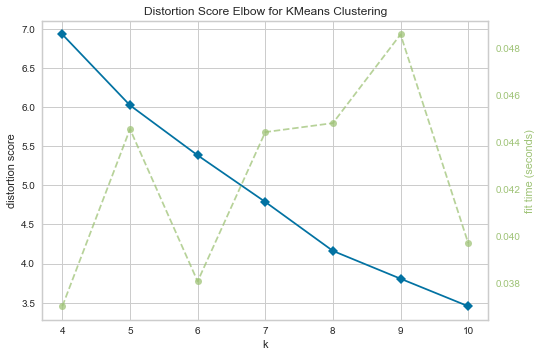

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [100]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

tokyo_part_clustering = tokyo_grouped.drop('Neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,11), locate_elbow=False)

visualizer.fit(tokyo_part_clustering)        # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

From the plot up here, it is difficult to select the best k value.

Run _k_-means to cluster the neighborhood into 5 clusters.

In [96]:
# set number of clusters
kclusters = 5

tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 4, 4, 1, 1, 1, 1, 4, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [97]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = neighborhoods

# merge neighborhoods with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
tokyo_merged = tokyo_merged.join(tokyo_venues_bar_count.set_index('Neighborhood'), on='Neighborhood')

tokyo_merged.head() # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

Finally, let's visualize the resulting clusters


In [98]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, b, n, cluster, bar in zip(tokyo_merged['Latitude'], tokyo_merged['Longitude'], tokyo_merged['Borough'], tokyo_merged['Neighborhood'],
                                   tokyo_merged['Cluster Labels'], tokyo_merged['Number of Bar']):
    #print(lat, lon, poi, cluster)
    label = folium.Popup(str(n) + ',' + str(b) + ',Cluster:' + str(cluster) + ',Bar:' + str(bar), parse_html=True)
    if np.isnan(cluster):
        color = 0
    else:
        color = int(cluster) - 1
    folium.CircleMarker(
        [lat, lon],
        radius=5 if np.isnan(bar) else int(bar)*3,
        popup=label,
        #color=rainbow[cluster-1],
        color=rainbow[color-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=rainbow[color-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters



Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 1

In [99]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 0, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
0,Nagatacho,139.743469,0.0,Bar,Hotel Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,2.0
2,Otemachi,139.766466,0.0,Wine Bar,Bar,Beer Bar,Cocktail Bar,Hotel Bar,Sake Bar,Champagne Bar,Hookah Bar,Juice Bar,Rooftop Bar,7.0
5,Yurakucho,139.761674,0.0,Hotel Bar,Bar,Beer Bar,Cocktail Bar,Sake Bar,Wine Bar,Champagne Bar,Hookah Bar,Juice Bar,Rooftop Bar,7.0
9,Kayabacho,139.779424,0.0,Wine Bar,Bar,Sake Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,5.0
11,Tsukiji,139.772592,0.0,Cocktail Bar,Juice Bar,Bar,Beer Bar,Champagne Bar,Hookah Bar,Hotel Bar,Rooftop Bar,Sake Bar,Sports Bar,2.0
12,Hatchobori,139.777128,0.0,Sake Bar,Wine Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,5.0
13,Shinkawa,139.779793,0.0,Wine Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,4.0
21,Roppongi,139.733498,0.0,Bar,Beer Bar,Hotel Bar,Cocktail Bar,Sake Bar,Whisky Bar,Wine Bar,Champagne Bar,Hookah Bar,Juice Bar,11.0
24,Azabu,139.733970,0.0,Sake Bar,Cocktail Bar,Wine Bar,Bar,Champagne Bar,Beer Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,10.0
72,Shibuya,139.702843,0.0,Bar,Sake Bar,Wine Bar,Beer Bar,Cocktail Bar,Champagne Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,10.0


#### Cluster 2

In [67]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 1, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
14,Tsukishima,139.784564,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,5.0
15,Kachidoki,139.777211,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,1.0
16,Tsukuda,139.785346,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,2.0
30,Ichigaya,139.735504,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,4.0
32,Sendagaya,139.711331,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,1.0
34,Hongo,139.760549,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,1.0
35,Yayoi,139.758220,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,1.0
37,Ueno,139.776075,1.0,Sake Bar,Cocktail Bar,Beer Bar,Juice Bar,Bar,Champagne Bar,Hookah Bar,Hotel Bar,Rooftop Bar,Sports Bar,16.0
39,Kinshicho,139.815043,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,12.0
40,Morishita,139.797044,1.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,9.0


#### Cluster 3

In [68]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 2, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
1,Kasumigaseki,139.750972,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,1.0
10,Ginza,139.766021,2.0,Bar,Beer Bar,Whisky Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,5.0
17,Odaiba,139.779364,2.0,Bar,Sake Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,3.0
56,Hatanodai,139.702630,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,1.0
71,Tamagawa,139.629300,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,1.0
122,Komae,139.575977,2.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,3.0


#### Cluster 4

In [69]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 3, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
3,Marunouchi,139.765222,3.0,Beer Bar,Wine Bar,Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,2.0
26,Shinjuku,139.701077,3.0,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,2.0
33,Yoyogi,139.702080,3.0,Bar,Beer Bar,Hotel Bar,Sake Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Juice Bar,Rooftop Bar,Sports Bar,8.0
55,Osaki,139.728279,3.0,Beer Bar,Juice Bar,Sports Bar,Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Rooftop Bar,Sake Bar,3.0
58,Tennozu,139.750878,3.0,Beer Bar,Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,Sports Bar,1.0
106,Hachioji,139.339467,3.0,Bar,Beer Bar,Sports Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sake Bar,3.0


#### Cluster 5

In [70]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 4, tokyo_merged.columns[[1] + list(range(5, tokyo_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Bar
4,Akihabara,139.774255,4.0,Sake Bar,Juice Bar,Bar,Beer Bar,Whisky Bar,Wine Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,17.0
6,Iidabashi,139.745979,4.0,Sake Bar,Bar,Beer Bar,Wine Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,6.0
7,Kanda,139.770917,4.0,Sake Bar,Beer Bar,Bar,Wine Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,15.0
8,Nihonbashi,139.774503,4.0,Sake Bar,Bar,Beer Bar,Cocktail Bar,Hotel Bar,Wine Bar,Champagne Bar,Hookah Bar,Juice Bar,Rooftop Bar,8.0
18,Shinbashi,139.756116,4.0,Sake Bar,Beer Bar,Juice Bar,Bar,Hotel Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Rooftop Bar,Sports Bar,15.0
19,Hamamatsucho,139.757062,4.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,7.0
20,Mita,139.747635,4.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,5.0
22,Toranomon,139.750056,4.0,Sake Bar,Bar,Beer Bar,Rooftop Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Sports Bar,5.0
25,Akasaka,139.735622,4.0,Sake Bar,Bar,Beer Bar,Champagne Bar,Cocktail Bar,Hookah Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,4.0
27,Takadanobaba,139.703874,4.0,Sake Bar,Beer Bar,Hookah Bar,Bar,Champagne Bar,Cocktail Bar,Hotel Bar,Juice Bar,Rooftop Bar,Sports Bar,9.0


## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of bars in Tokyo (~2000 in our initial area of interest which was 12x12km around Tokyo), there are pockets of low bar density fairly close to city center. Highest concentration of bars was detected north and west from Tokyo, so we focused our attention to areas south, south-east and east, corresponding to boroughs Kreuzberg, Friedrichshain and south-east corner of central Mitte borough. Another borough was identified as potentially interesting, but our attention was focused on Kreuzberg and Friedrichshain which offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics *and* a number of pockets of low bar density.

After directing our attention to this more narrow area of interest (covering approx. 5x5km south-east from Tokyo) we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with more than two bars in radius of 250m and those with an bar closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all this is 15 zones containing largest number of potential new bar locations based on number of and distance to existing venues - both bars in general and Italian bars particularly. This, of course, does not imply that those zones are actually optimal locations for a new bar! Purpose of this analysis was to only provide info on areas close to Tokyo center but not crowded with existing bars (particularly Italian) - it is entirely possible that there is a very good reason for small number of bars in any of those areas, reasons which would make them unsuitable for a new bar regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Tokyo areas close to center with low number of bars (particularly bars) in order to aid stakeholders in narrowing down the search for optimal location for a new bar. By calculating bar density distribution from Foursquare data we have first identified general boroughs that justify further analysis (Kreuzberg and Friedrichshain), and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby bars. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal bar location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.